# **Problem #1: Concrete Crack Detection**



### **Speaker**: Aleksandre Tsertsvadze
San Diego State University, Georgia
<br>
Third-year student

**Goal**: This project aims to provide an accessible approach to AI development by allowing users to use pre-trained models, utilize ready datasets, develop models, and deploy them via an API.

# 🗂️ Dataset Preparation

*   Installs the **gdown** Python package inside Colab.
*   **gdown** allows downloading files directly from Google Drive using the file’s shareable ID.
- Uses **gdown** to fetch a file stored on Google Drive.  
- `--id` specifies the **Google Drive file ID**.  
- `-O` specifies the **output path**, saving it as `/content/ConcreteCrack.rar` inside Colab.  
- The dataset is a **RAR archive** containing images of **cracks** and **non-cracks**.  

In [ ]:
!pip install gdown
!gdown --id 1DKmg52xmNJl82mZErjngfvOgjRz_kMjp -O /content/ConcreteCrack.rar

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1DKmg52xmNJl82mZErjngfvOgjRz_kMjp
From (redirected): https://drive.google.com/uc?id=1DKmg52xmNJl82mZErjngfvOgjRz_kMjp&confirm=t&uuid=8cb9084a-9c03-43d1-b2fa-406079fd0bea
To: /content/ConcreteCrack.rar
100% 327M/327M [00:06<00:00, 49.0MB/s]


- Installs the **unrar** utility inside the Colab Linux environment.  
- Colab does not come with RAR extraction tools pre-installed, so this step is required to **unpack `.rar` files**.

In [ ]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


- `unrar x` extracts the contents of the RAR file.  
- `/content/ConcreteCrack.rar` is the **compressed dataset file**.  
- `/content/` is the **target folder** where files will be extracted.  
- After this step, your dataset will be available in **`/content/ConcreteCrack/`**.

In [ ]:
!unrar x /content/ConcreteCrack.rar /content/

Streaming output truncated to the last 5000 lines.
Extracting  /content/ConcreteCrack/Positive/15003_1.jpg                   89%  OK 
Extracting  /content/ConcreteCrack/Positive/15004_1.jpg                   89%  OK 
Extracting  /content/ConcreteCrack/Positive/15005_1.jpg                   89%  OK 
Extracting  /content/ConcreteCrack/Positive/15006_1.jpg                   89%  OK 
Extracting  /content/ConcreteCrack/Positive/15007_1.jpg                   89%  OK 
Extracting  /content/ConcreteCrack/Positive/15008_1.jpg                   89%  OK 
Extracting  /content/ConcreteCrack/Positive/15009_1.jpg                   89%  OK 
Extracting  /content/ConcreteCrack/Positive/15010_1.jpg                   89%  OK 
Extracting  /content/ConcreteCrack/Positive/15011_1.jpg                   89%  OK 
Extracting  /content/ConcreteCrack/Positive/15012_1.jpg                   89%  OK 
Extracting  /content/Concrete

# 🔄 Data Loaders Preparation

In [ ]:
from fastai.vision.all import *
from pathlib import Path

data_path = Path("/content/ConcreteCrack/")

dls = ImageDataLoaders.from_folder(
    data_path,
    valid_pct = 0.2,
    seed = 42,
    item_tfms = Resize(224),
    batch_tfms=aug_transforms(do_flip=True, flip_vert=True, max_rotate=15, max_zoom=1.0),
    bs=32
)

- `data_path = Path("/content/ConcreteCrack/")`  
  Sets the path to the dataset folder extracted earlier.

- `ImageDataLoaders.from_folder(...)`  
  Creates **training and validation dataloaders** directly from the folder structure:
  - `valid_pct=0.2` → Uses **20%** of images for validation, 80% for training.  
  - `seed=42` → Ensures reproducibility of the train/validation split.  
  - `item_tfms=Resize(224)` → Resizes all images to **224×224** pixels (standard for ResNet).  
  - `batch_tfms=aug_transforms(...)` → Applies **data augmentation** such as:  
    - Random horizontal/vertical flips.  
    - Small rotations (up to 15°).  
    - Zoom up to 1.0×.  
    These transformations help the model generalize better.  
  - `bs=32` → Uses a **batch size of 32** images for efficient GPU training.

Displays a sample batch of **8 images** with their labels (Positive = crack, Negative = no crack).

This is useful to **visually confirm** that the dataset is loaded correctly and augmentations look reasonable.

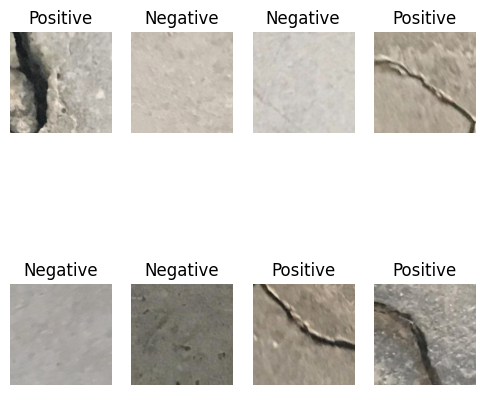

In [ ]:
dls.show_batch(max_n=8, figsize=(6, 6))

# ⚙️ Model Creation

- **`vision_learner(...)`** builds a transfer-learning model with:
  - **Backbone**: ResNet-34 pretrained on ImageNet.  
  - **Metric**: accuracy is tracked at each epoch.  
  - **Callbacks**:
    - `CSVLogger` → saves training history to `history.csv`.  
    - `SaveModelCallback` → saves the best-performing model automatically.  

In [ ]:
from fastai.callback.progress import CSVLogger
from fastai.callback.tracker import SaveModelCallback

learn = vision_learner(
    dls, resnet34, metrics=accuracy,
    cbs=[
        CSVLogger(fname='history.csv'),          # persist curves (loss/metrics)
        SaveModelCallback(monitor='accuracy')    # keep best model
    ]
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 154MB/s]


# 🚀 Training with Fine-Tuning

- **`learn.fine_tune(30)`** performs transfer learning:
  - 1 epoch with frozen backbone (only classifier head is trained).  
  - 29 epochs with entire model unfrozen for full fine-tuning.  
- Training outputs:
  - `train_loss` → training loss per epoch.  
  - `valid_loss` → validation loss per epoch.  
  - `accuracy` → accuracy on validation set.  
  - `time` → runtime per epoch.  
- Result: model reaches **>99% accuracy**, with low validation loss and no signs of strong overfitting.

In [ ]:
learn.fine_tune(30)

epoch,train_loss,valid_loss,accuracy,time
0,0.032124,0.008743,0.996875,02:43


Better model found at epoch 0 with accuracy value: 0.996874988079071.


epoch,train_loss,valid_loss,accuracy,time
0,0.008456,0.005685,0.998375,03:31
1,0.012245,0.003556,0.998750,03:30
2,0.004297,0.003605,0.998750,03:31
3,0.007255,0.004392,0.998750,03:32
4,0.018768,0.003524,0.999125,03:30
5,0.004264,0.003525,0.998875,03:30
6,0.009009,0.004046,0.999000,03:32
7,0.007572,0.007596,0.998500,03:31
8,0.004424,0.004178,0.998375,03:33
9,0.008713,0.005898,0.998250,03:34


Better model found at epoch 0 with accuracy value: 0.9983749985694885.
Better model found at epoch 1 with accuracy value: 0.9987499713897705.
Better model found at epoch 4 with accuracy value: 0.9991250038146973.
Better model found at epoch 11 with accuracy value: 0.9992499947547913.
Better model found at epoch 19 with accuracy value: 0.9993749856948853.
Better model found at epoch 26 with accuracy value: 0.9994999766349792.


# 📊 Performance Visualization


- Interpretation:
  - Both train and validation losses decrease and stay close → good fit, no major overfitting.  
  - Accuracy stabilizes above 99%.

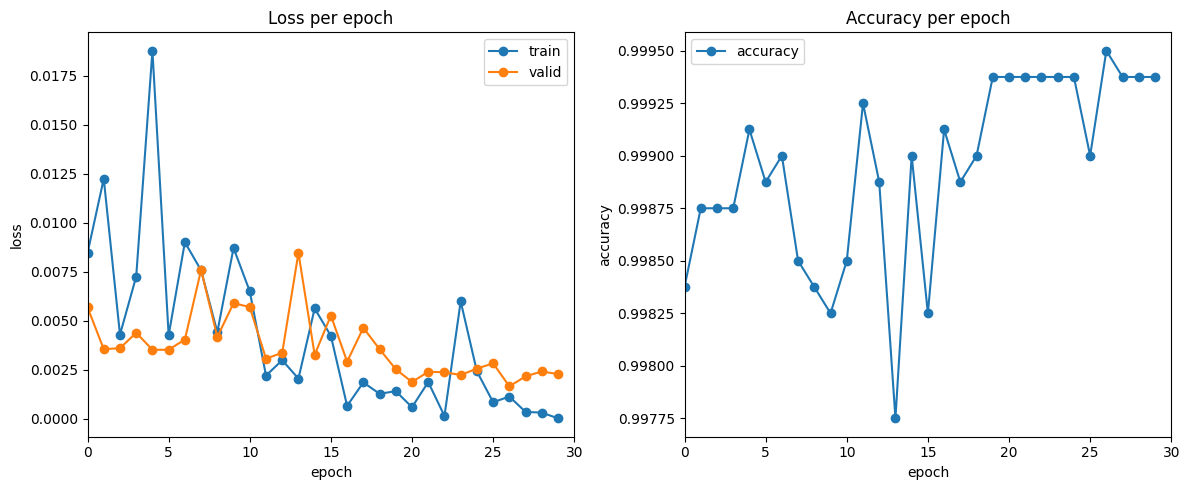

In [ ]:
# @title Loss per Epoch / Accuracy per epoch
import pandas as pd
import matplotlib.pyplot as plt

# Load history
hist = pd.read_csv('/content/ConcreteCrack/history.csv')
hist.index.name = 'epoch'

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Loss curves ---
axes[0].plot(hist.index, hist['train_loss'], marker='o', label='train')
axes[0].plot(hist.index, hist['valid_loss'], marker='o', label='valid')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[0].set_title('Loss per epoch')
axes[0].set_xlim(0, 30)
axes[0].legend()

# --- Accuracy curve ---
if 'accuracy' in hist.columns:
    axes[1].plot(hist.index, hist['accuracy'], marker='o', label='accuracy')
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('accuracy')
    axes[1].set_title('Accuracy per epoch')
    axes[1].set_xlim(0, 30)
    axes[1].legend()

plt.tight_layout()

# 🧾 Model Evaluation

- **`ClassificationInterpretation.from_learner(learn)`**:
  - `interp.plot_confusion_matrix()` → visualizes true vs predicted labels.  
  - `interp.plot_top_losses()` → shows hardest images (prediction/actual/loss/probability).  

- **Interpretation**:
  - Confusion matrix confirms very few mistakes.  
  - Top-loss images reveal common failure modes (hairline cracks missed, or shadows mistaken as cracks).

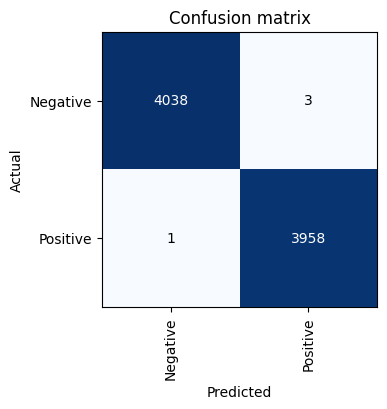

In [ ]:
# @title Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4))

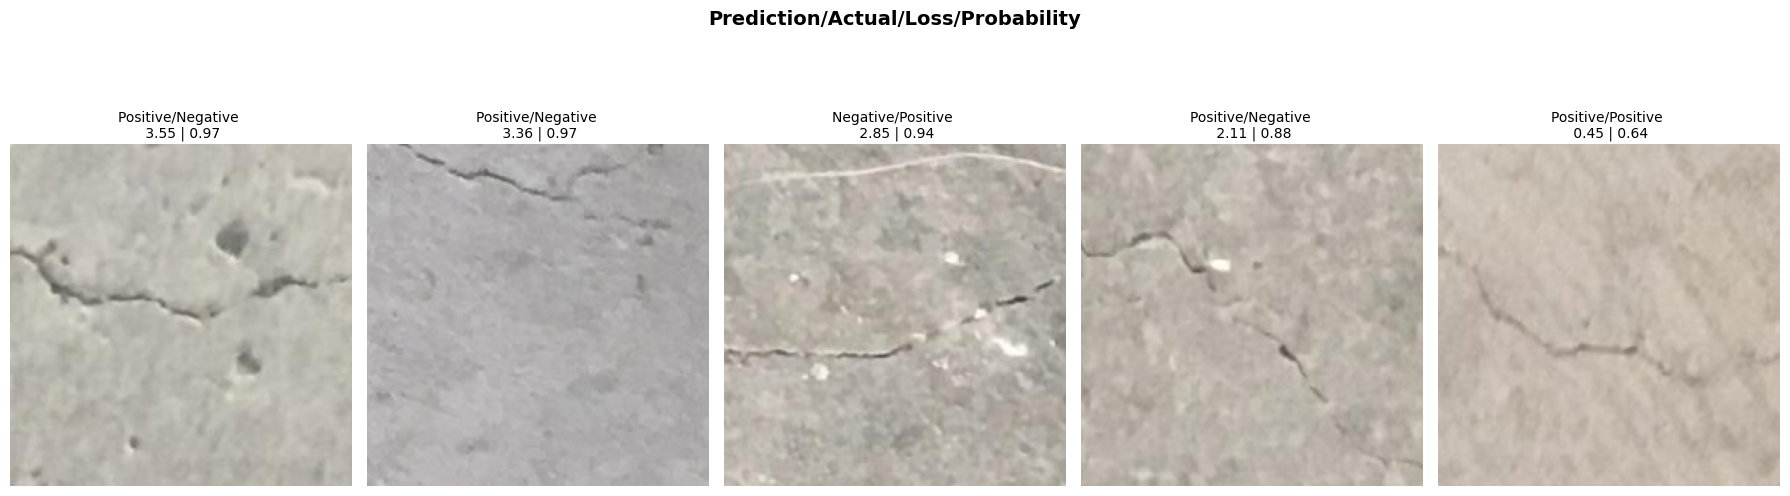

In [ ]:
# @title Visualization: Prediction/Actual and Loss/Probability
import matplotlib.pyplot as plt

# Draw with more space
interp.plot_top_losses(5, nrows=1, figsize=(18, 6))

# Re-wrap each subplot title so it doesn’t collide
for ax in plt.gcf().axes:
    t = ax.get_title()
    # turn "Negative/Positive / 13.08 / 1.00" into two lines
    t = t.replace(" / ", " | ").replace("|", "\n", 1)  # first separator becomes newline
    ax.set_title(t, fontsize=10, wrap=True)

plt.tight_layout()
plt.show()

# 💾 Model Exporting

- **Remove Callbacks before Export**
  - `learn.remove_cbs([CSVLogger])` → removes the CSVLogger to avoid **PicklingError**, since callbacks sometimes keep file handles that cannot be saved.  
  - `learn.export('crack_classifier.pkl')` → saves the trained model, data pipeline, and class labels into a single `.pkl` file.  
  - This exported file allows inference later without retraining.

In [ ]:
learn.remove_cbs([CSVLogger])
learn.export('crack_classifier.pkl')

- **Load the Exported Model**
  - `load_learner("ConcreteCrack/crack_classifier.pkl")` → loads the exported model back into memory.  
  - `learn.dls.vocab` → prints the available class labels, e.g. `['Negative', 'Positive']`.

In [ ]:
import torch, os
learn = load_learner("ConcreteCrack/crack_classifier.pkl")

print("Classes:", learn.dls.vocab)

Classes: ['Negative', 'Positive']


/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


- **Run Inference on a New Image**
  - `learn.predict("ConcreteCrack/Positive/00001.jpg")` → runs prediction on a single image.  
  - Output includes:  
    - **Predicted label** → e.g., `Positive` (crack) or `Negative` (no crack).  
    - **Index** of the predicted class.  
    - **Class probabilities** → confidence scores for each class.  

In [ ]:
learn.predict("ConcreteCrack/Positive/00001.jpg")

('Positive', tensor(1), tensor([1.3641e-10, 1.0000e+00]))

# 📱 QR code of the API

<center>

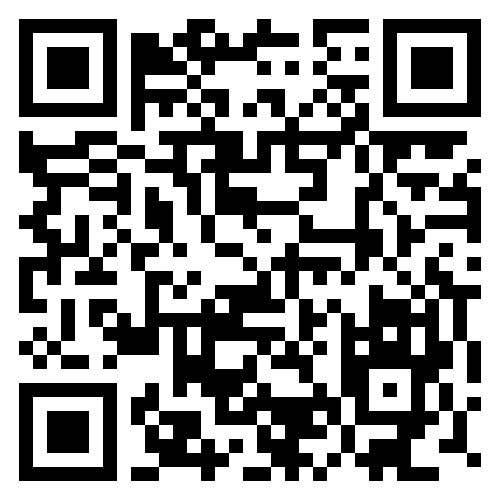

</center>

# Thank you for your Attention!